In [2]:
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms as transforms

In [3]:
predicter_path = '/home/lab-wen.yaoli/CODE/AFEW/test/model/shape_predictor_68_face_landmarks.dat'
# 导入人脸检测模型
detector = dlib.get_frontal_face_detector()
# 导入检测人脸特征点的模型
sp = dlib.shape_predictor(predicter_path)

In [4]:
class Img_read(object):
    def __call__(self, img_dir):
        bgr_img = cv2.imread(img_dir)
        return bgr_img

In [5]:
class Img_contrast_histeqClahe(object):
    def __call__(self, bgr_img, limit=2.0, size=(8,8)):
        img_yuv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YUV)
        clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=size)
        img_yu = img_yuv[:,:,0]
        img_yuv[:,:,0] = clahe.apply(img_yu)
        bgr_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        return bgr_img

In [6]:
class Img_face_alignment(object):
    def __call__(self, bgr_img, max_face=True):
        # opencv的颜色空间是BGR，需要转为RGB才能用在dlib中
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        # 检测图片中的人脸，第二个为上采样率，第三个为阈值
        dets, scores, idx = detector.run(rgb_img, 2, -0.30)
        # 检测到的人脸数量
        num_faces = len(dets)
        # print(num_faces)
        if num_faces == 0:
            print("Sorry, there were no faces found")
            return bgr_img
        # 识别人脸特征点，并保存下来
        # Find the 5 face landmarks we need to do the alignment
        faces = dlib.full_object_detections()
        if max_face:
            #取最大面部
            s_max = 0 
            det_max = None
            for det in dets:
                s = (det.right()-det.left())*(det.bottom()-det.top())
                if s > s_max:
                    s_max = s
                    det_max = det
                    faces.append(sp(rgb_img, det_max))
        else:
            for detection in dets:
                faces.append(sp(rgb_img, detection))

        # 人脸对齐
        rgb_images = dlib.get_face_chips(rgb_img, faces, size=224, padding=0.25)
        # print(type(rgb_images[0]))
        bgr_images = [cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR) for rgb_image in rgb_images]
        return bgr_images

In [7]:
class Img_cv2PIL(object):
    def __call__(self, img_cv):
        img_PIL = Image.fromarray(cv2.cvtColor(img_cv,cv2.COLOR_BGR2RGB))
        return img_PIL 

In [8]:
class Img_PIL2cv(object):
    def __call__(self, img_PIL):
        img_cv = cv2.cvtColor(np.asarray(img_PIL),cv2.COLOR_RGB2BGR) 
        return img_cv

In [9]:
class Img_crop():  
    def __init__(self, scale, crop_type):
        self.scale = scale
        self.crop_type = crop_type
        self.cv2PIL = Img_cv2PIL()
        self.PIL2cv = Img_PIL2cv()
    def __call__(self, img_cv):
        img_PIL = self.cv2PIL(img_cv)
        ori_width, ori_height = img_PIL.size
        delta_width = ori_width*self.scale
        delta_height =  ori_height*self.scale
        mid_width = ori_width/2
        mid_height = ori_height/2
        if self.crop_type == 'right':
            crop_box = (ori_width-delta_width, mid_height-delta_height/2,
                        ori_width, mid_height+delta_height/2)
        elif self.crop_type == 'left':
            crop_box = (0, mid_height-delta_height/2,
                        0+delta_width, mid_height+delta_height/2)
        elif self.crop_type == "top":
            crop_box = (mid_width-delta_width/2, 0,
                        mid_width+delta_width/2, 0+delta_height)
        elif self.crop_type == "bottom":
            crop_box = (mid_width-delta_width/2, ori_height-delta_height,
                        mid_width+delta_width/2, ori_height)
        elif self.crop_type == 'right_top':
            crop_box = (ori_width-delta_width, 0,
                        ori_width, 0+delta_height)         
        elif self.crop_type == 'right_bottom':
            crop_box = (ori_width-delta_width, ori_height-delta_height,
                        ori_width, ori_height)
        elif self.crop_type == 'left_top':
            crop_box = (0, 0,
                    0+delta_width, 0+delta_height)
        elif self.crop_type == 'left_bottom':
            crop_box = (0, ori_height-delta_height,
                        0+delta_width, ori_height)
        elif self.crop_type == 'center':
            crop_box = (mid_width-delta_width/2, mid_height-delta_height/2,
                    mid_width+delta_width/2, mid_height+delta_height/2)
        else:
            print('error')
            return None
        img_crop_PIL = img_PIL.crop(crop_box)
        img_crop_cv = self.PIL2cv(img_crop_PIL)
        return img_crop_cv




In [13]:
class Img_show(object):   
    def __call__(self, bgr_images):
        if isinstance(bgr_images,list):
            for bgr_image in bgr_images:
                #image_cnt += 1
                cv_bgr_image = np.array(bgr_image).astype(np.uint8)# 先转换为numpy数组
                rgb_img = cv2.cvtColor(cv_bgr_image, cv2.COLOR_BGR2RGB)
                plt.imshow(rgb_img)
        else:
            cv_bgr_image = np.array(bgr_images).astype(np.uint8)# 先转换为numpy数组
            rgb_img = cv2.cvtColor(cv_bgr_image, cv2.COLOR_BGR2RGB)
            plt.imshow(rgb_img)

In [17]:
class Img_save(object):
    def __init__(self, save_dir):
        self.save_dir = save_dir
    def __call__(self, img):
        if img is None:
            print(self.save_dir)
        else:
            cv2.imwrite(self.save_dir, img)
        return img

In [12]:
class Img_selector(object):
    def __call__(self, images, i=0):
        if images is None:
            img = None
        else:
            img = images[0]
        return img

In [10]:
class Img_Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


In [18]:
dir = "/home/lab-wen.yaoli/CODE/preprocess/test1.jpg"
img_save = Img_save(dir)
img = None
img_save(img)


/home/lab-wen.yaoli/CODE/preprocess/test1.jpg


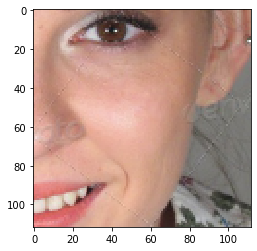

In [17]:
transform = Img_Compose([Img_read(), Img_face_alignment(), Img_selector(), Img_crop(scale=0.5, crop_type="right"), Img_show()])
transform(dir) 

In [ ]:
transform = Img_Compose([img_read, img_crop, img_show])
transform(dir)

In [13]:
img_read = Img_read()
cv2PIL = Img_cv2PIL()

TypeError: Img_cv2PIL() missing 1 required positional argument: 'object'

In [20]:
img = img_read(dir)
cv2PIL = Img_cv2PIL
cv2PIL(img)

In [ ]:
img = cv2.imread(dir)
x = img_crop(img, scale=0.5, crop_type="right")
show_img(x)

In [13]:
transform = Img_Compose([img_read, img_crop, img_show])

In [13]:
img = img_read(dir)
img_crop(img)

AttributeError: 'NoneType' object has no attribute 'size'

In [14]:
transform(dir)

/157Dataset/data-wen.yaoli/dataset/affectnet/1/0b2663f63172b858f55aed1e18a9bdb2a7398fe2edcfa832ec2928d7.JPG
xxxx
[[[128 125 127]
  [128 125 127]
  [128 126 126]
  ...
  [118 121 119]
  [117 119 119]
  [117 119 119]]

 [[127 124 126]
  [127 124 126]
  [127 125 125]
  ...
  [118 121 119]
  [118 120 120]
  [117 119 119]]

 [[125 124 126]
  [124 123 125]
  [124 123 125]
  ...
  [118 121 119]
  [117 119 119]
  [117 119 119]]

 ...

 [[173 120  39]
  [180 139  54]
  [159 128  43]
  ...
  [147 117 188]
  [139 107 178]
  [135  99 175]]

 [[174 123  29]
  [209 168  83]
  [186 151  77]
  ...
  [130  94 176]
  [121  82 162]
  [116  75 156]]

 [[187 141  53]
  [212 173  95]
  [200 162  97]
  ...
  [123  84 170]
  [121  81 159]
  [126  84 161]]]
xxxx


TypeError: __init__() takes 1 positional argument but 2 were given